<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Sentiment analysis con Embeddings + LSTM

### Objetivo
El objetivo es utilizar las críticas de compradores de ropa para que el sistema determine la evaluación del comprador y su crítica (cuantas estrellas le asigna al producto).

In [1]:
!pip install --upgrade --no-cache-dir gdown --quiet

In [2]:
import numpy as np
import random
import io
import pickle
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow import keras
from tensorflow.keras import layers

from keras.utils import to_categorical

from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding

import math

### Datos
Utilizaremos como dataset críticas de compradores de ropa (eCommerce) los cuales puntuaron a cada prenda con un puntaje de 1 a 5 estrellas.\
Referencia del dataset: [LINK](https://www.kaggle.com/nicapotato/womens-ecommerce-clothing-reviews/version/1)

In [3]:
# Descargar la carpeta de dataset
import os
import gdown
if os.access('clothing_ecommerce_reviews.csv', os.F_OK) is False:
    url = 'https://drive.google.com/uc?id=1Urn1UFSrodN5BuW6-sc_igtaySGRwhV8'
    output = 'clothing_ecommerce_reviews.csv'
    gdown.download(url, output, quiet=False)
else:
    print("El dataset ya se encuentra descargado")

El dataset ya se encuentra descargado


In [4]:
# Armar el dataset
df = pd.read_csv('clothing_ecommerce_reviews.csv')
df.drop(columns = ['Unnamed: 0'], inplace = True)
df.head()

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


### 1 - Limpieza de datos
Alumno:
- Del dataset unicamente utilizar las columnas "Review Text" y "Rating.
- Tranformar el rating 1-5 a una escala numérica de 0 a 4.



In [5]:
df_reviews = df.loc[:, ['Review Text', 'Rating']].dropna()
df_reviews['Rating'] = df_reviews['Rating'] - 1
df_reviews.head()

,Review Text,Rating
0,Absolutely wonderful - silky and sexy and comf...,3
1,Love this dress! it's sooo pretty. i happene...,4
2,I had such high hopes for this dress and reall...,2
3,"I love, love, love this jumpsuit. it's fun, fl...",4
4,This shirt is very flattering to all due to th...,4


In [6]:
df_reviews.columns

Index(['Review Text', 'Rating'], dtype='object')

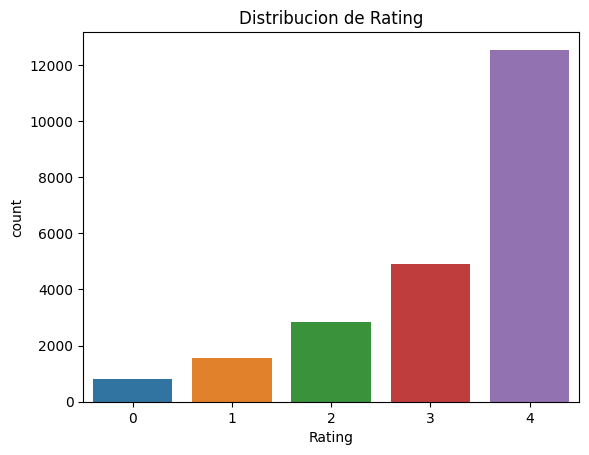

In [7]:
# Alumno: Observar como está distribuido el dataset respecto a la columna Rating
# es decir, observar que tan balanceado se encuentra respecot a cada clase

plt.figure()
sns.countplot(x='Rating', data=df_reviews)
plt.title('Distribucion de Rating')
plt.show()


In [8]:
# Alumno: tomar la columna de las review y almacenarlo todo en un vector numpy de reviews
reviews = df_reviews['Review Text'].values

In [9]:
# Alumno: Cuantas reviews (rows) hay para evaluar?

cantidad_reviews = df_reviews.shape[0]

print(f"Total de revisiones para evaluar: {cantidad_reviews}")


Total de revisiones para evaluar: 22641


In [10]:
# Alumno: Concatenar todas las reviews para armar el corpus
corpus = ""

for review in df_reviews['Review Text']:
    corpus += review + " "
print("Corpus completo:")
print(corpus[:500])


Corpus completo:
Absolutely wonderful - silky and sexy and comfortable Love this dress!  it's sooo pretty.  i happened to find it in a store, and i'm glad i did bc i never would have ordered it online bc it's petite.  i bought a petite and am 5'8".  i love the length on me- hits just a little below the knee.  would definitely be a true midi on someone who is truly petite. I had such high hopes for this dress and really wanted it to work for me. i initially ordered the petite small (my usual size) but i found thi


In [11]:
# Alumno: ¿Cuál es la longitud de ese corpus?

longitud_corpus = len(corpus)

print(f"La longitud del corpus es: {longitud_corpus} caracteres")


La longitud del corpus es: 7011644 caracteres


In [12]:
# Alumno: Utilizar "text_to_word_sequence" para separar las palabras en tokens
# recordar que text_to_word_sequence automaticamente quita los signos de puntuacion y pasa el texto a lowercase
from keras.preprocessing.text import text_to_word_sequence

tokens = text_to_word_sequence(corpus)


In [13]:
# Alumno: Dar un vistazo a los primeros 20 tokens/palabras
print("Primeros 20 tokens:")
print(tokens[:20])

Primeros 20 tokens:
['absolutely', 'wonderful', 'silky', 'and', 'sexy', 'and', 'comfortable', 'love', 'this', 'dress', "it's", 'sooo', 'pretty', 'i', 'happened', 'to', 'find', 'it', 'in', 'a']


In [14]:
# Alumno: ¿Cuántos tokens/palabras hay?
print(f"Total de tokens: {len(tokens)}")

Total de tokens: 1372203


In [15]:
# Alumno: Tokenizar las palabras con el Tokenizer de Keras
# Definir una máxima cantidad de palabras a utilizar:
# num_words --> the maximum number of words to keep, based on word frequency.
# Only the most common num_words-1 words will be kept.
from keras.preprocessing.text import Tokenizer
num_words = 1000
vocab_size = num_words
token = Tokenizer(num_words=1000)
token.fit_on_texts(tokens)

In [16]:
# Alumno: Obtener el diccionario de palabra (word) a índice
# y observar la cantidad total del vocabulario

from keras.preprocessing.text import Tokenizer


print(f"Tamaño del vocabulario: {len(token.word_index)} palabras")


Tamaño del vocabulario: 14847 palabras


In [17]:
# Alumno: Convertir las palabras/tokens a números
sequences = token.texts_to_sequences(reviews)


In [18]:
# Alumno: Determinar cual es la oración más larga

max_length = max(len(s) for s in sequences)

print(f"La oración más larga tiene {max_length} palabras.")


La oración más larga tiene 112 palabras.


In [19]:
# Alumno: Realizar padding de las sentencias al mismo tamaño
# tomando de referencia la máxima sentencia
from tensorflow.keras.utils import pad_sequences
maxlen = 115

padded_sequences = pad_sequences(sequences, maxlen=maxlen, padding='post', truncating='post', value=0)

In [20]:
# Alumno: Observar las dimensiones de la variable input
print("Forma de 'padded_sequences':", padded_sequences.shape)

Forma de 'padded_sequences': (22641, 115)


In [21]:
# Alumno tomar la columna rating y alcemacenarla en una variable "y" transformada a oneHotEncoding
# Su shape debe ser equivalente la cantidad de rows del corpus y a la cantidad
# de clases que se deseen predecir (en este ejemplo son 5)

import numpy as np
from sklearn.preprocessing import OneHotEncoder
ratings = df_reviews['Rating']
encoder = OneHotEncoder(sparse=False)
y = encoder.fit_transform(ratings.values.reshape(-1, 1))

print("Tamaño 'y':", y.shape)


Tamaño 'y': (22641, 5)


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [22]:
from sklearn.model_selection import train_test_split

# Alumno: Dividir los datos en train y test
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, y, test_size=0.2, random_state=10, stratify=y)
print("Forma de X_train:", X_train.shape)
print("Forma de y_train:", y_train.shape)
print("Forma de X_test:", X_test.shape)
print("Forma de y_test:", y_test.shape)


Forma de X_train: (18112, 115)
Forma de y_train: (18112, 5)
Forma de X_test: (4529, 115)
Forma de y_test: (4529, 5)


X_train: (18112, 115)


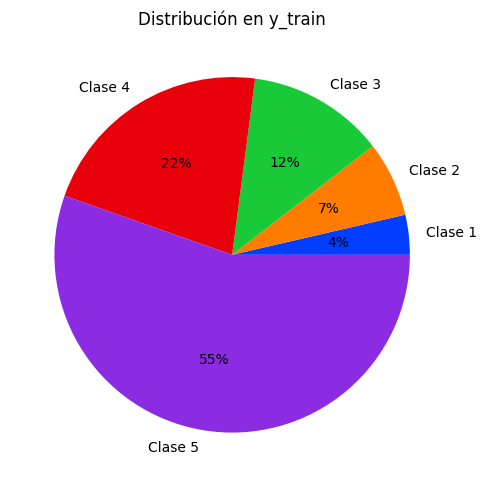

In [23]:
from sklearn.model_selection import train_test_split

# Alumno: Dividir los datos en train y test
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, y, test_size=0.2, random_state=42, stratify=y)
print(f"X_train: {X_train.shape}")

class_counts_train = y_train.sum(axis=0)
class_counts_test = y_test.sum(axis=0)

class_labels = [f'Clase {i+1}' for i in range(y_train.shape[1])]

plt.figure(figsize=(5, 5))
plt.pie(class_counts_train, labels=class_labels, autopct='%.0f%%', colors=sns.color_palette('bright'))
plt.title(f'Distribución en y_train')

plt.tight_layout()
plt.show()



In [24]:
from imblearn.over_sampling import RandomOverSampler

# Aplico Random OverSampler para el sobremuestreo
oversampler = RandomOverSampler(sampling_strategy='all')
X_train_OS, y_train_OS = oversampler.fit_resample(X_train, y_train)


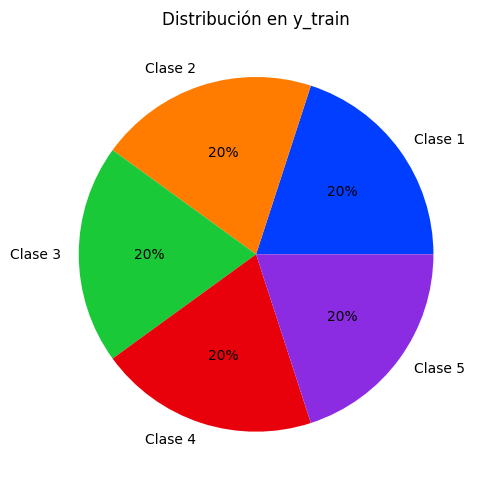

In [25]:
class_labels = [f'Clase {i+1}' for i in range(y_train_OS.shape[1])]

class_counts_train = y_train_OS.sum(axis=0)

plt.figure(figsize=(5, 5))
plt.pie(class_counts_train, labels=class_labels, autopct='%.0f%%', colors=sns.color_palette('bright'))
plt.title(f'Distribución en y_train')

plt.tight_layout()
plt.show()


In [26]:
# Alumno: determinar la dimensiones de entrada y salida
in_shape = X_train_OS.shape[1]
out_shape = df_reviews['Rating'].nunique()
print("Dim Entrada", in_shape, ", Dim Salida", out_shape)

Dim Entrada 115 , Dim Salida 5


### 2 - Entrenar el modelo con Embeddings + LSTM

In [27]:
# Alumno: Entrene su modelo con LSTM entrenando sus propios embeddings
# o utilizando embeddings pre-entrenados.
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout

model = Sequential()
# input_dim = vocab_size (max n_words)
# input_length = sentencias con padding a 200
# output_dim = 50 --> crear embeddings de tamaño 50
model.add(Embedding(input_dim=vocab_size+1, output_dim=50, input_length=in_shape))
model.add(LSTM(units=64, return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(units=128))

model.add(Dense(units=64, activation='relu'))
model.add(Dropout(rate=0.3))
model.add(Dense(units=out_shape, activation='sigmoid'))

model.compile(optimizer="adam",
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 115, 50)           50050     
                                                                 
 lstm (LSTM)                 (None, 115, 64)           29440     
                                                                 
 dropout (Dropout)           (None, 115, 64)           0         
                                                                 
 lstm_1 (LSTM)               (None, 128)               98816     
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 5)                 3

In [28]:
# Alumno: Entrene su modelo con LSTM entrenando sus propios embeddings
# o utilizando embeddings pre-entrenados.
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout

model = Sequential()
# input_dim = vocab_size (max n_words)
# input_length = setencias con padding a 200
# output_dim = 50 --> crear embeddings de tamaño 50
model.add(Embedding(input_dim=vocab_size+1, output_dim=50, input_length=in_shape))
model.add(LSTM(units=64, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=64)) # La última capa LSTM no lleva return_sequences

model.add(Dense(units=128, activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(units=64, activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(units=out_shape, activation='softmax'))

model.compile(optimizer="adam",
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 115, 50)           50050     
                                                                 
 lstm_2 (LSTM)               (None, 115, 64)           29440     
                                                                 
 dropout_2 (Dropout)         (None, 115, 64)           0         
                                                                 
 lstm_3 (LSTM)               (None, 64)                33024     
                                                                 
 dense_2 (Dense)             (None, 128)               8320      
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 64)               

In [29]:
modelo = model.fit(X_train_OS, y_train_OS, validation_data=(X_test, y_test), epochs=30)

Epoch 1/30
1568/1568 [==============================] - 60s 31ms/step - loss: 1.6099 - accuracy: 0.1992 - val_loss: 1.6158 - val_accuracy: 0.0362
Epoch 2/30
1568/1568 [==============================] - 25s 16ms/step - loss: 1.6093 - accuracy: 0.1974 - val_loss: 1.6342 - val_accuracy: 0.0378
Epoch 3/30
1568/1568 [==============================] - 23s 15ms/step - loss: 1.5889 - accuracy: 0.2388 - val_loss: 1.6559 - val_accuracy: 0.0369
Epoch 4/30
1568/1568 [==============================] - 23s 15ms/step - loss: 1.3917 - accuracy: 0.3562 - val_loss: 1.1046 - val_accuracy: 0.5273
Epoch 5/30
1568/1568 [==============================] - 23s 15ms/step - loss: 1.0806 - accuracy: 0.5297 - val_loss: 1.0074 - val_accuracy: 0.5769
Epoch 6/30
1568/1568 [==============================] - 23s 14ms/step - loss: 0.9268 - accuracy: 0.6141 - val_loss: 1.0435 - val_accuracy: 0.5668
Epoch 7/30
1568/1568 [==============================] - 23s 15ms/step - loss: 0.8161 - accuracy: 0.6707 - val_loss: 1.1110 -

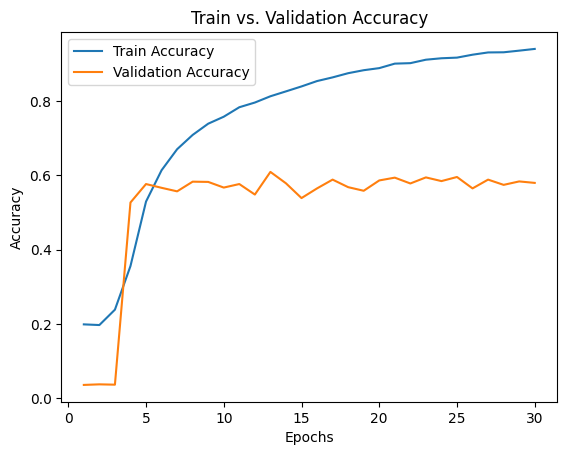

In [30]:
train_accuracy = modelo.history['accuracy']
val_accuracy = modelo.history['val_accuracy']
plt.plot(range(1, len(train_accuracy) + 1), train_accuracy, label='Train Accuracy')
plt.plot(range(1, len(val_accuracy) + 1), val_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train vs. Validation Accuracy')
plt.legend()
plt.show()


In [31]:
# Haciendo predicciones con el modelo entrenado para el conjunto de datos con oversampling
from sklearn.metrics import f1_score
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)

# Calculando F1 score
f1sc = f1_score(np.argmax(y_test, axis=1), y_pred, average='micro')
print(f'F1 score: {f1sc}')

142/142 [==============================] - 2s 6ms/step
F1 score: 0.5800397438728196


In [32]:
modelo_2 = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=30)

Epoch 1/30
566/566 [==============================] - 10s 13ms/step - loss: 0.2833 - accuracy: 0.8999 - val_loss: 1.8765 - val_accuracy: 0.5794
Epoch 2/30
566/566 [==============================] - 9s 16ms/step - loss: 0.2711 - accuracy: 0.9055 - val_loss: 1.8643 - val_accuracy: 0.5992
Epoch 3/30
566/566 [==============================] - 8s 14ms/step - loss: 0.2664 - accuracy: 0.9049 - val_loss: 1.9227 - val_accuracy: 0.5940
Epoch 4/30
566/566 [==============================] - 8s 13ms/step - loss: 0.2555 - accuracy: 0.9128 - val_loss: 1.9292 - val_accuracy: 0.5599
Epoch 5/30
566/566 [==============================] - 8s 15ms/step - loss: 0.2459 - accuracy: 0.9156 - val_loss: 1.9567 - val_accuracy: 0.5946
Epoch 6/30
566/566 [==============================] - 7s 13ms/step - loss: 0.2349 - accuracy: 0.9194 - val_loss: 1.9265 - val_accuracy: 0.5962
Epoch 7/30
566/566 [==============================] - 9s 15ms/step - loss: 0.2219 - accuracy: 0.9288 - val_loss: 1.9253 - val_accuracy: 0.590

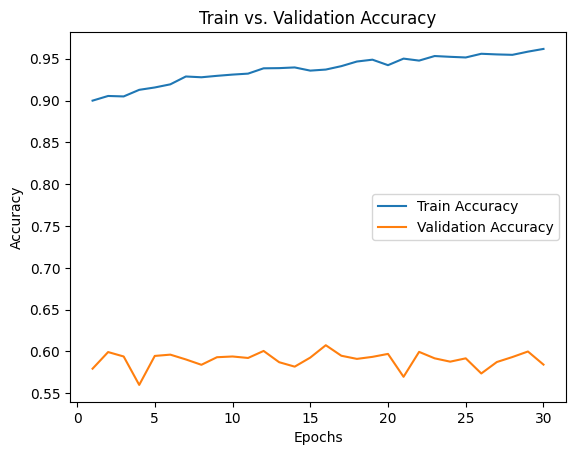

In [33]:
train_accuracy = modelo_2.history['accuracy']
val_accuracy = modelo_2.history['val_accuracy']
plt.plot(range(1, len(train_accuracy) + 1), train_accuracy, label='Train Accuracy')
plt.plot(range(1, len(val_accuracy) + 1), val_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train vs. Validation Accuracy')
plt.legend()
plt.show()


In [34]:
# Haciendo predicciones con el modelo entrenado para el conjunto de datos sin oversampling
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)

# Calculando F1 score
f1sc = f1_score(np.argmax(y_test, axis=1), y_pred, average='micro')
print(f'F1 score: {f1sc}')

142/142 [==============================] - 1s 5ms/step
F1 score: 0.5842349304482226
